In [2]:
import fairsearchcore as fsc
from fairsearchcore.models import FairScoreDoc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from functools import partial
from multiprocessing import Pool

# One question analysis

In [3]:
df_for_fair = pd.read_csv("df_for_fair_74681417.csv")
print(len(df_for_fair))
df_for_fair.head()

350


,u_id,pscore,developed_country
0,100297,2.263848,1.0
1,3874623,2.024328,1.0
2,5923139,1.902712,1.0
3,7574575,1.897878,0.0
4,325565,1.845899,1.0


In [4]:
k = 100  # number of topK elements returned (value should be between 10 and 400)
p = 0.6398  # 1−0,3602, proportion of protected candidates in the topK elements (value should be between 0.02 and 0.98)
alpha = 0.05  # significance level (value should be between 0.01 and 0.15)

# create the Fair object
fair = fsc.Fair(k, p, alpha)

In [5]:
recom_ranking = [
    FairScoreDoc(int(u_id), pscore, bool(1 - dev_country))
    for _, (u_id, pscore, dev_country) in df_for_fair.iterrows()
]
fair.is_fair(recom_ranking[:k])

False

In [31]:
def until_next_prob(mtable, countProtected, i):
    return 1/(((countProtected < mtable[i:]) == False).sum()+1)

def global_prob(mtable, countProtected, i):
    return (mtable[-1] - countProtected) / (len(mtable) - i)

def balanced_prob(mtable, countProtected, i):
    return (until_next_prob(mtable, countProtected, i) * global_prob(mtable, countProtected, i)) ** 0.5

def safe_balanced_prob(mtable, countProtected, i):
    if ((countProtected < mtable[i:]) == False).sum() == 0:
        return 1
    if mtable[-1] == countProtected:
        return until_next_prob(mtable, countProtected, i)
    return (until_next_prob(mtable, countProtected, i) * global_prob(mtable, countProtected, i)) ** 0.5

prob_functions = [
    ("until_next", until_next_prob),
    ("global", global_prob),
    ("balanced", balanced_prob),
    ("safe_balanced", safe_balanced_prob),
]

In [32]:
def fair_top_k(k, protected_candidates, non_protected_candidates, mtable, prob_func):
    """    
    Parameters:
    ----------
    k : int
        the expected length of the ranking
    protected_candidates : [FairScoreDoc]
        array of protected class:`candidates <fairsearhcore.models.FairScoreDoc>`, assumed to be
        sorted by item score in descending order
    non_protected_candidates : [FairScoreDoc]
        array of non-protected class:`candidates <fairsearhcore.models.FairScoreDoc>`, assumed to be
        sorted by item score in descending order
        significance level for the binomial cumulative distribution function -> minimum probability at
        which a fair ranking contains the minProp amount of protected candidates
    Return:
    ------
    an array of elements in the form of `dict` that maximizes ordering and
    selection fairness
    the left-over candidates that were not selected into the ranking, sorted color-blindly
    """
    mtable = np.array(mtable)
    result = []
    countProtected = 0

    idxProtected = 0
    idxNonProtected = 0

    for i in range(k):
        if idxProtected >= len(protected_candidates) and idxNonProtected >= len(non_protected_candidates):
            # no more candidates available, return list shorter than k
            return result, []
        if idxProtected >= len(protected_candidates):
            # no more protected candidates available, take non-protected instead
            result.append(non_protected_candidates[idxNonProtected])
            idxNonProtected += 1

        elif idxNonProtected >= len(non_protected_candidates):
            # no more non-protected candidates available, take protected instead
            result.append(protected_candidates[idxProtected])
            idxProtected += 1
            countProtected += 1
        elif np.random.rand() < prob_func(mtable, countProtected, i): # Here is the prob change
            # add a protected candidate
            result.append(protected_candidates[idxProtected])
            idxProtected += 1
            countProtected += 1
        else:
            # find the best candidate available
            if protected_candidates[idxProtected].score >= non_protected_candidates[idxNonProtected].score:
                # the best is a protected one
                result.append(protected_candidates[idxProtected])
                idxProtected += 1
                countProtected += 1
            else:
                # the best is a non-protected one
                result.append(non_protected_candidates[idxNonProtected])
                idxNonProtected += 1

    return result

def _re_rank_improved(fair_ranker, ranking, adjust, prob_func):
    """
    Applies FA*IR re-ranking to the input ranking and boolean whether to use an adjusted mtable
    :param ranking:     The ranking to be re-ranked (list of FairScoreDoc)
    :return:
    """
    protected = []
    non_protected = []
    for item in ranking:
        if item.is_protected:
            protected.append(item)
        else:
            non_protected.append(item)

    return fair_top_k(fair_ranker.k, protected, non_protected,
                      fair_ranker.create_adjusted_mtable() if adjust else fair_ranker.create_unadjusted_mtable(),
                      prob_func)

re_ranked = _re_rank_improved(fair, recom_ranking, True, balanced_prob)
fair.is_fair(re_ranked)

False

until_next is fair: True


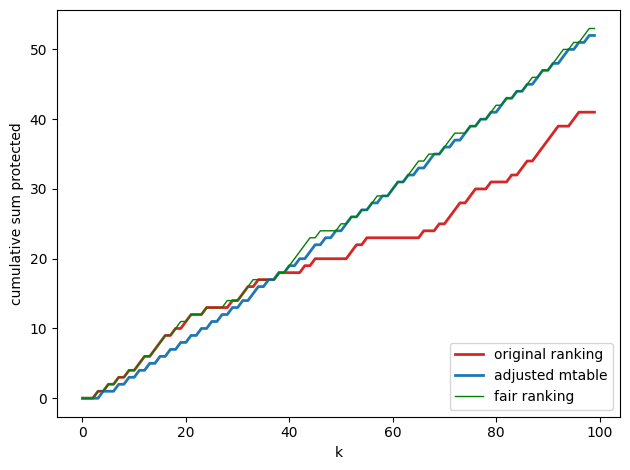

global is fair: False


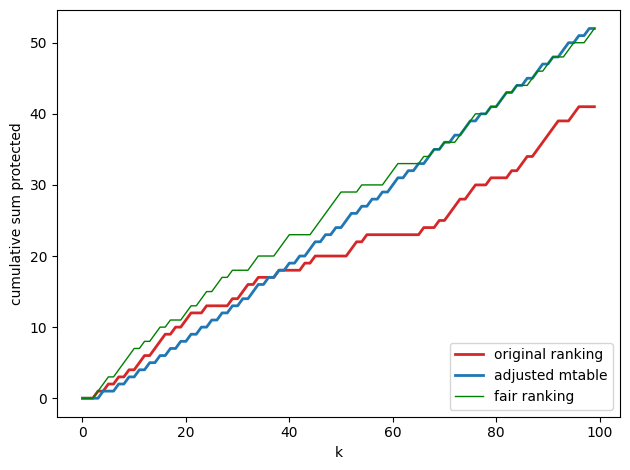

balanced is fair: False


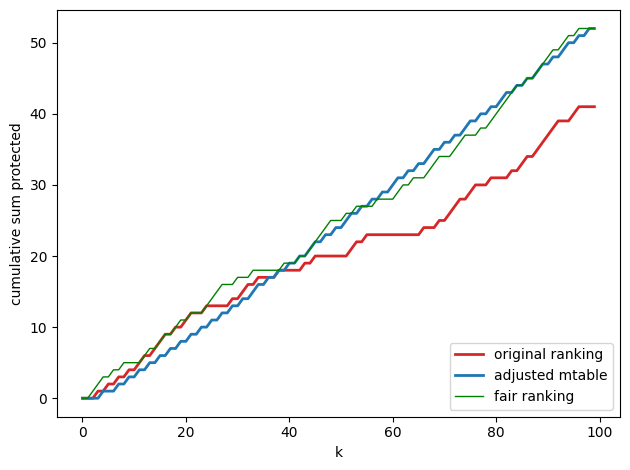

safe_balanced is fair: True


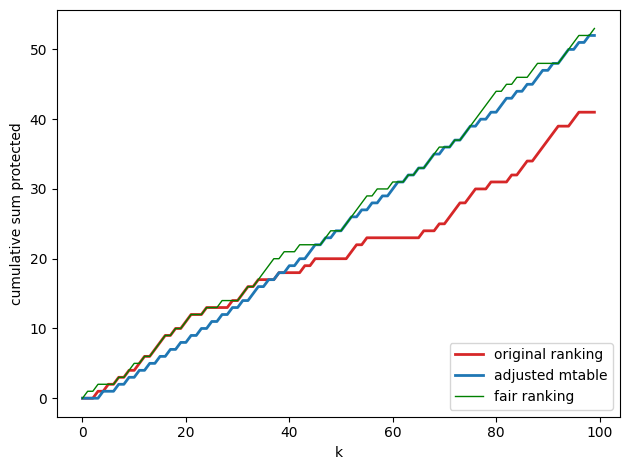

In [33]:
for f_name, prob_f in prob_functions:
    re_ranked = _re_rank_improved(fair, recom_ranking, True, prob_f)
    print(f"{f_name} is fair: {fair.is_fair(re_ranked)}")

    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("cumulative sum protected")
    ax.plot(
        range(k),
        (1 - df_for_fair[:k]["developed_country"]).cumsum(),
        color=color,
        label="original ranking",
        linewidth=2,
    )
    ax.plot(range(k), fair.create_adjusted_mtable(), label="adjusted mtable", linewidth=2)
    ax.plot(
        range(k),
        np.cumsum([int(re_r.is_protected) for re_r in re_ranked]),
        color="green",
        label="fair ranking",
        linewidth=1,
    )
    ax.legend(loc="lower right")

    fig.tight_layout()
    fig.savefig(f"cumpro_part_{f_name}.pdf")
    plt.show()

until_next


/home/dml/.pyenv/versions/3.7.14/envs/so_q_recom_fair/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dml/.pyenv/versions/3.7.14/envs/so_q_recom_fair/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


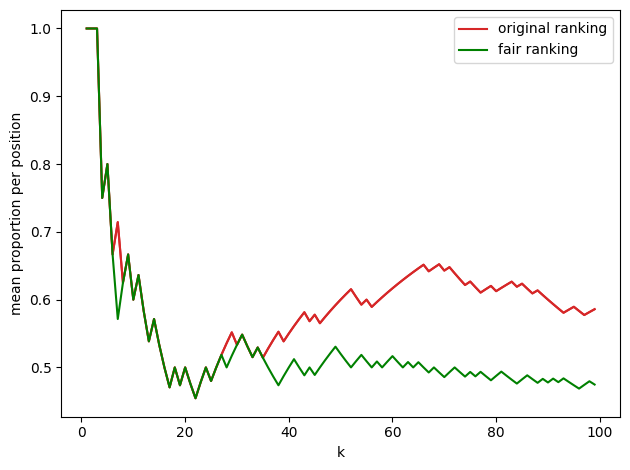

global


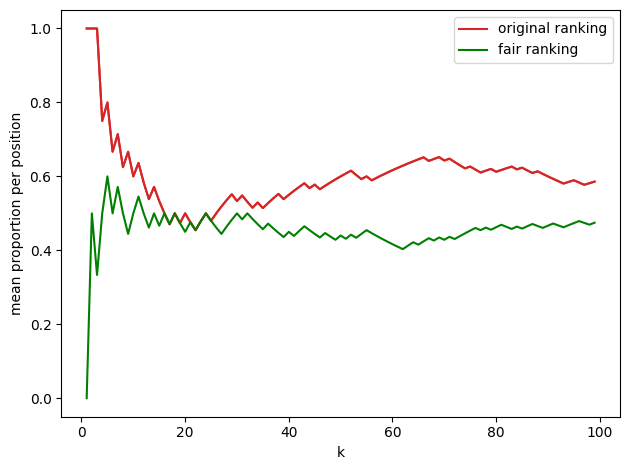

balanced


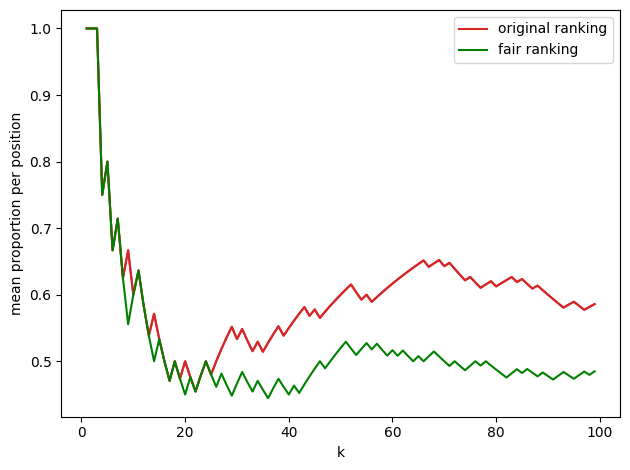

safe_balanced


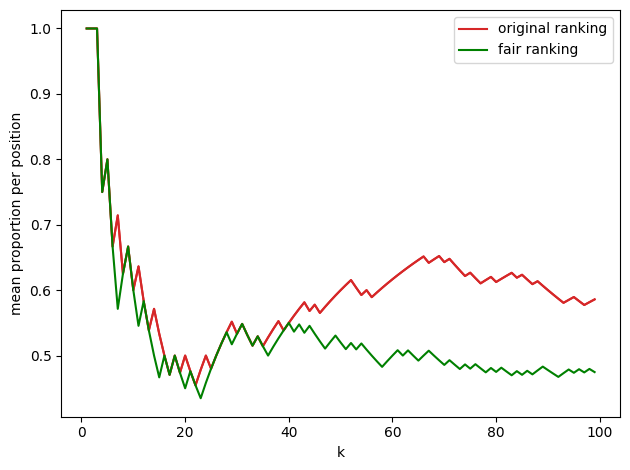

In [34]:
for f_name, prob_f in prob_functions:
    re_ranked = _re_rank_improved(fair, recom_ranking, True, prob_f)
    print(f_name)
    fig, ax = plt.subplots()

    mean_proportion = []
    mean_proportion_fair = []
    
    for top_k in range(k):
        mean_proportion.append(df_for_fair.head(top_k)["developed_country"].mean())
        mean_proportion_fair.append(
            np.mean([1 - int(re_r.is_protected) for re_r in re_ranked[:top_k]])
        )

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("mean proportion per position")
    ax.plot(range(k), mean_proportion, color=color)
    ax.plot(range(k), mean_proportion, color=color, label="original ranking")
    ax.plot(range(k), mean_proportion_fair, color="green", label="fair ranking")
    ax.legend()

    fig.tight_layout()
    plt.show()

# All questions

In [35]:
df_for_fair_complete = pd.read_csv("df_for_fair_complete.csv")
df_for_fair_complete.head()

,q_id,u_id,pscore,developed_country
0,70547027,100297,2.340971,1.0
1,70547027,7574575,2.266549,0.0
2,70547027,11923558,2.071728,0.0
3,70547027,1624921,2.033441,1.0
4,70547027,325565,1.930067,1.0


In [36]:
len(df_for_fair_complete["q_id"].unique())

3973

In [37]:
def create_fair_score_doc(q_group):
    return [FairScoreDoc(int(u_id), pscore, bool(1 - dev_country))
            for q_id, u_id, pscore, dev_country in q_group.to_numpy()]

questions_rankings = df_for_fair_complete.groupby("q_id").apply(create_fair_score_doc)
questions_rankings = list(zip(questions_rankings.index, questions_rankings.to_numpy()))

In [38]:
questions_rankings_is_fair = [
    (q_id, fair.is_fair(ranking[:k])) for q_id, ranking in questions_rankings
]

In [39]:
questions_rankings_is_fair[0]

(70547027, False)

In [ ]:
questions_rankings_fair = defaultdict(list)
questions_rankings_fair_is_fair = defaultdict(list)

def re_rank_and_fair(prob_f, q_id_ranking):
    q_id, ranking = q_id_ranking
    re_ranked = _re_rank_improved(fair, ranking, True, prob_f)
    return q_id, re_ranked, fair.is_fair(re_ranked)

for f_name, prob_f in prob_functions:
    re_rank_and_fair_w_func = partial(re_rank_and_fair, prob_f)
    with Pool(8) as p:
        re_rank_result = p.map(re_rank_and_fair_w_func, questions_rankings)
    for q_id, re_rank_ranking, re_rank_is_fair in re_rank_result:
        questions_rankings_fair[f_name].append((q_id, re_rank_ranking))
        questions_rankings_fair_is_fair[f_name].append((q_id, re_rank_is_fair))

In [41]:
questions_rankings_fair_is_fair['until_next'][0], questions_rankings_fair_is_fair['safe_balanced'][0]

((70547027, True), (70547027, True))

In [42]:
original_fair_qs = sum(is_fair for _, is_fair in questions_rankings_is_fair)
print(f"original fair questions: {original_fair_qs}")

for f_name, _ in prob_functions:
    fair_qs = sum(is_fair for _, is_fair in questions_rankings_fair_is_fair[f_name])
    print(f"fair questions using {f_name}: {fair_qs}")

original fair questions: 2
fair questions using until_next: 3973
fair questions using global: 545
fair questions using balanced: 133
fair questions using safe_balanced: 3973


In [43]:
top_k = list(range(1, 100))

def calculate_mean_proportion(k):
    return (df_for_fair_complete.groupby("q_id")[["developed_country", "q_id"]]
            .apply(lambda x: x.head(k)["developed_country"].mean())
            .mean())

with Pool(8) as p:
    mean_proportion = p.map(calculate_mean_proportion, top_k)

In [44]:
def calculate_mean_proportion(questions_rankings_fair, k):
    return np.mean([np.mean([1 - int(re_r.is_protected) for re_r in ranking[:k]])
                    for _, ranking in questions_rankings_fair])

mean_proportion_fair = dict()

for f_name, _ in prob_functions:
    calculate_mean_proportion_w_qr = partial(calculate_mean_proportion, questions_rankings_fair[f_name])
    with Pool(8) as p:
        mean_proportion_fair[f_name] = p.map(calculate_mean_proportion_w_qr, top_k)
    

until_next


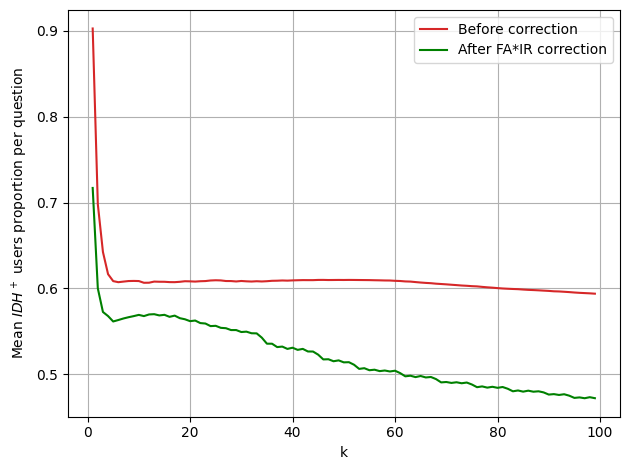

global


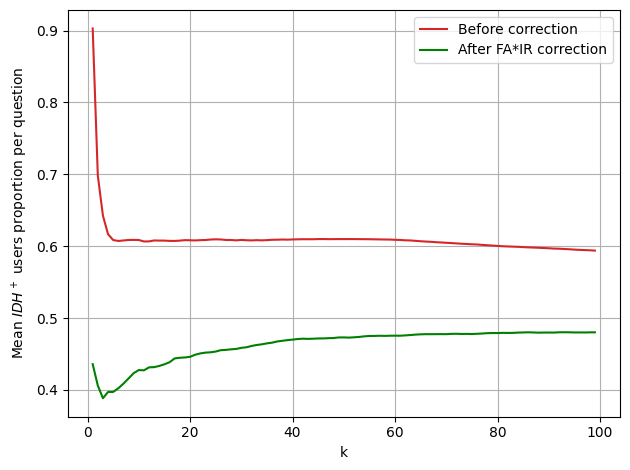

balanced


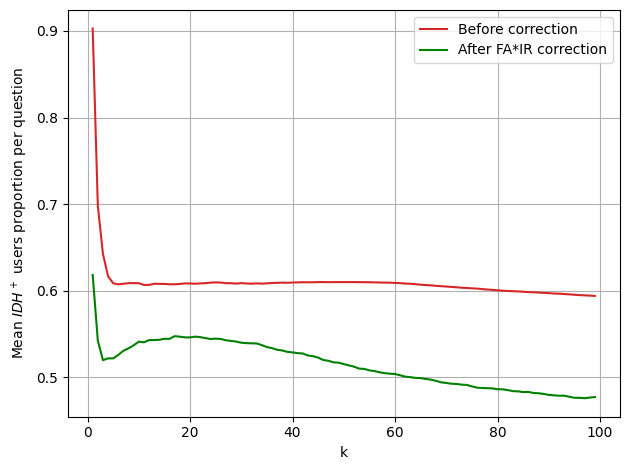

safe_balanced


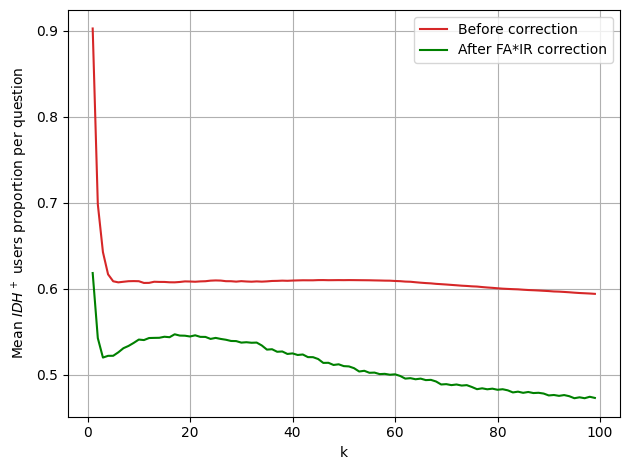

In [45]:
for f_name, _ in prob_functions:
    print(f_name)
    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("Mean $IDH^+$ users proportion per question")
    ax.plot(top_k, mean_proportion, color=color, label="Before correction")
    ax.plot(top_k, mean_proportion_fair[f_name], color="green", label="After FA*IR correction")
    ax.legend()

    fig.tight_layout()
    plt.grid()
    fig.savefig(f"protected_prop_mean_{f_name}.pdf")
    plt.show()

until_next


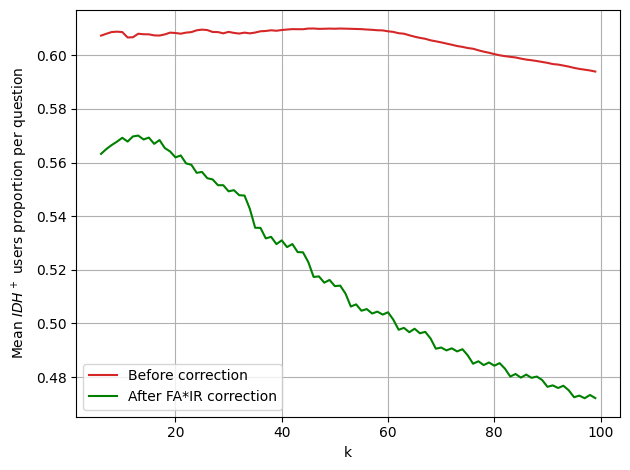

global


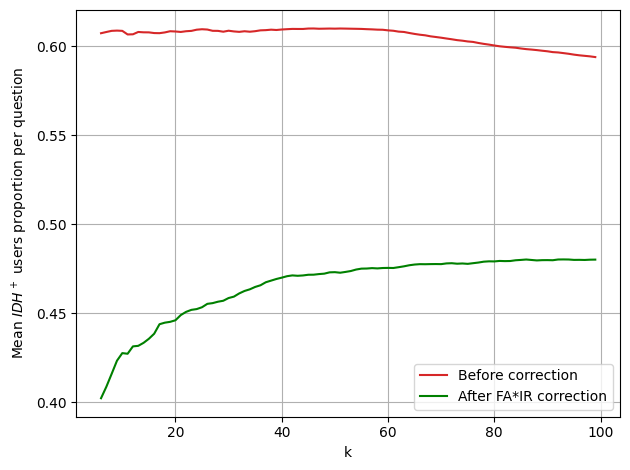

balanced


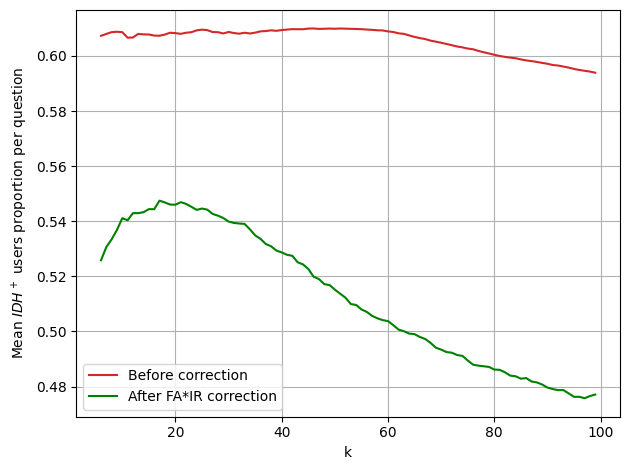

safe_balanced


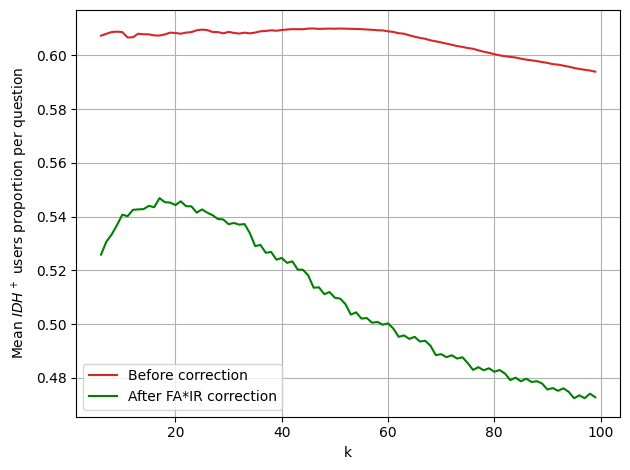

In [46]:
for f_name, _ in prob_functions:
    print(f_name)
    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("Mean $IDH^+$ users proportion per question")
    ax.plot(top_k[5:], mean_proportion[5:], color=color, label="Before correction")
    ax.plot(top_k[5:], mean_proportion_fair[f_name][5:], color="green", label="After FA*IR correction")
    ax.legend()

    fig.tight_layout()
    plt.grid()
    fig.savefig(f"protected_prop_mean_{f_name}_5.pdf")
    plt.show()

average ratio of non protected candidates

In [47]:
df_for_fair_complete["pos"] = (
    df_for_fair_complete[["q_id", "u_id"]].groupby("q_id").cumcount() + 1
)
df_for_fair_complete.head()

,q_id,u_id,pscore,developed_country,pos
0,70547027,100297,2.340971,1.0,1
1,70547027,7574575,2.266549,0.0,2
2,70547027,11923558,2.071728,0.0,3
3,70547027,1624921,2.033441,1.0,4
4,70547027,325565,1.930067,1.0,5


In [48]:
dev_country_per_pos = dict()
for f_name, _ in prob_functions:
    dev_country_per_pos_aux = [0] * 350
    for _, candidates in questions_rankings_fair[f_name]:
        for pos, candidate in enumerate(candidates):
            dev_country_per_pos_aux[pos] += (1 - int(candidate.is_protected)) / len(questions_rankings_fair[f_name])
        dev_country_per_pos[f_name] = dev_country_per_pos_aux

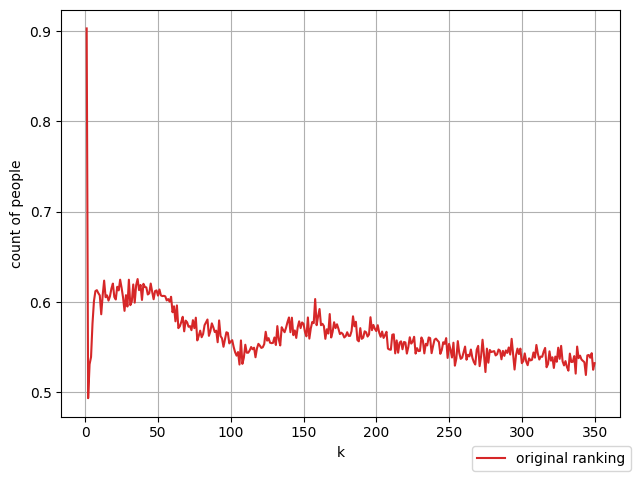

In [49]:
fig, ax = plt.subplots()

color = "tab:red"
ax.set_xlabel("k")
ax.set_ylabel("count of people")
ax.plot(
    list(range(1, 351)),
    df_for_fair_complete[["developed_country", "pos"]]
    .groupby("pos")
    .mean()
    .values.flatten(),
    color=color,
    label="original ranking",
)
fig.legend(loc="lower right")

fig.tight_layout()
plt.grid()
plt.show()

until_next


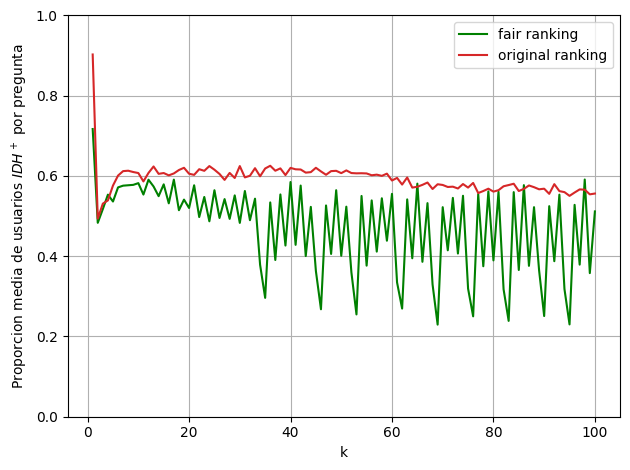

global


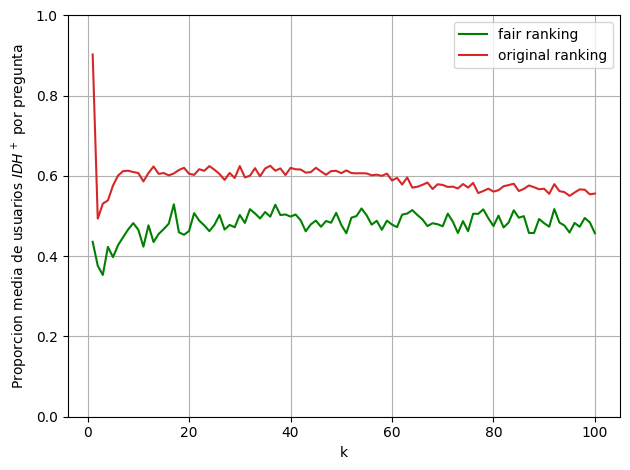

balanced


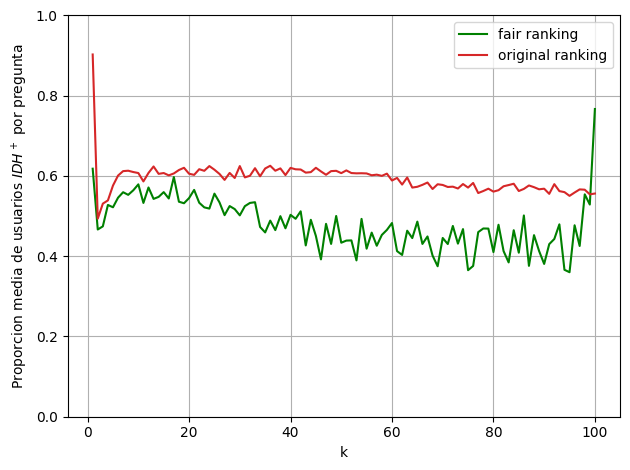

safe_balanced


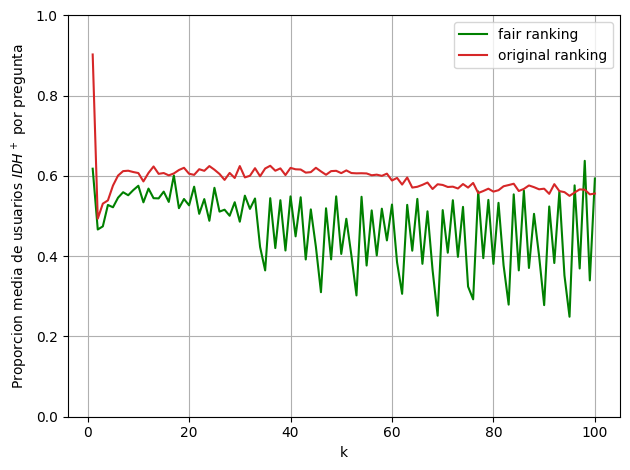

In [50]:
positions = list(range(1, 101))
original_rank_devc = (df_for_fair_complete[["developed_country", "pos"]]
                        .groupby("pos").mean().values.flatten()[:100])

for f_name, _ in prob_functions:
    print(f_name)
    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("Proporcion media de usuarios $IDH^+$ por pregunta")
    ax.plot(
        positions, dev_country_per_pos[f_name][:100], color="green", label="fair ranking"
    )
    ax.plot(
        positions,
        original_rank_devc,
        color=color,
        label="original ranking",
    )
    ax.legend()
    ax.set_ylim([0, 1])

    fig.tight_layout()
    plt.grid()
    fig.savefig(f"devcount_{f_name}.pdf")
    plt.show()

In [51]:
rows = []

for q_id, ranking in questions_rankings:
    for r in ranking:
        rows.append((q_id, 1 - int(r.is_protected), r.id))

fair_dataset = pd.DataFrame(rows, columns=["q_id", "developed_country", "u_id"])

In [52]:
fair_dataset.head()

,q_id,developed_country,u_id
0,70547027,1,100297
1,70547027,0,7574575
2,70547027,0,11923558
3,70547027,1,1624921
4,70547027,1,325565


In [53]:
after_fair_data = dict()

for f_name, _ in prob_functions:
    after_fair_data_aux = [
        (int(q_id), r.id, 1 - int(r.is_protected), idx, r.score)
        for q_id, questions in questions_rankings_fair[f_name]
        for idx, r in enumerate(questions)
    ]
    after_fair_data[f_name] = pd.DataFrame(
        after_fair_data_aux, columns=["q_id", "u_id", "developed_country", "idx", "pscore"]
    )

after_fair_data["balanced"].head()

,q_id,u_id,developed_country,idx,pscore
0,70547027,100297,1,0,2.340971
1,70547027,7574575,0,1,2.266549
2,70547027,11923558,0,2,2.071728
3,70547027,1624921,1,3,2.033441
4,70547027,325565,1,4,1.930067


In [54]:
fair_dataset["protected"] = 1 - fair_dataset["developed_country"]
fair_dataset["idx"] = fair_dataset.groupby("q_id")["q_id"].cumcount()
fair_dataset["rank"] = 1 + fair_dataset["idx"]
fair_dataset["cumsum"] = fair_dataset.groupby("q_id", group_keys=False).apply(
    lambda x: x["protected"].cumsum()
)

before_fair_cumsum = fair_dataset[["rank", "cumsum"]].groupby("rank").mean()
before_fair_cumsum.head()

,cumsum
rank,
1,0.097156
2,0.603574
3,1.072489
4,1.533350
5,1.957211


In [55]:
for f_name, _ in prob_functions:
    after_fair_data[f_name]["protected"] = 1 - after_fair_data[f_name]["developed_country"]
    after_fair_data[f_name]["rank"] = 1 + after_fair_data[f_name]["idx"]

    after_fair_data[f_name]["cumsum"] = after_fair_data[f_name].groupby("q_id", group_keys=False).apply(
        lambda x: x["protected"].cumsum()
    )

after_fair_data["balanced"].head()

,q_id,u_id,developed_country,idx,pscore,protected,rank,cumsum
0,70547027,100297,1,0,2.340971,0,1,0
1,70547027,7574575,0,1,2.266549,1,2,1
2,70547027,11923558,0,2,2.071728,1,3,2
3,70547027,1624921,1,3,2.033441,0,4,2
4,70547027,325565,1,4,1.930067,0,5,2


In [56]:
after_fair_cumsum = dict()
for f_name, _ in prob_functions:
    after_fair_cumsum[f_name] = after_fair_data[f_name][["rank", "cumsum"]].groupby("rank").mean()

after_fair_cumsum["balanced"].head()

,cumsum
rank,
1,0.381827
2,0.915177
3,1.440725
4,1.912912
5,2.390888


until_next


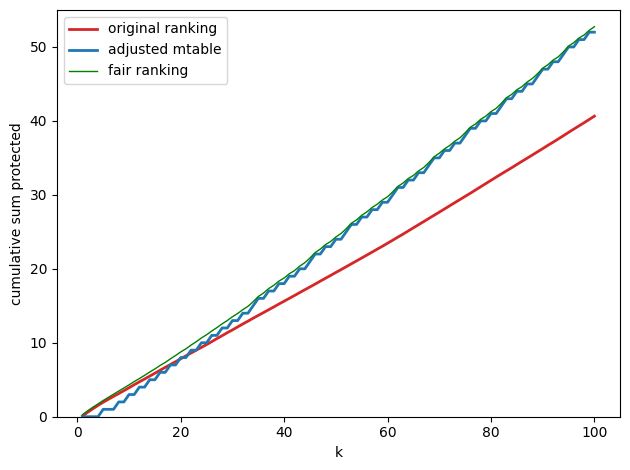

global


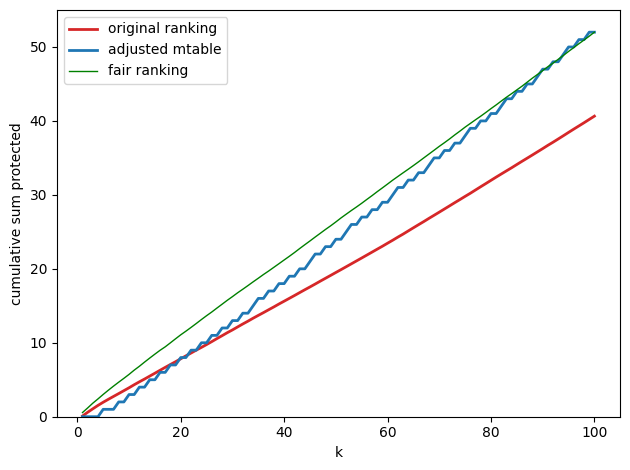

balanced


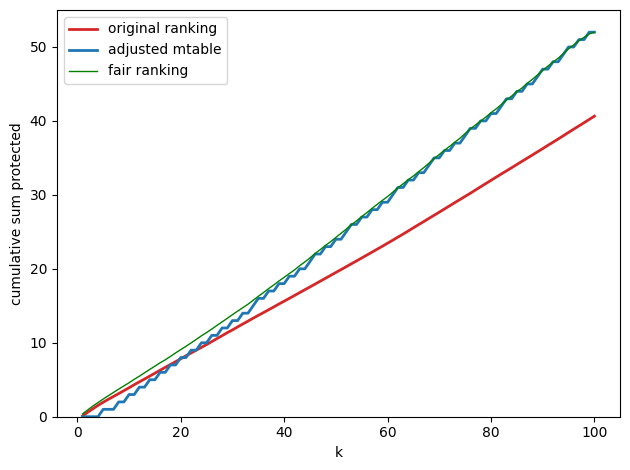

safe_balanced


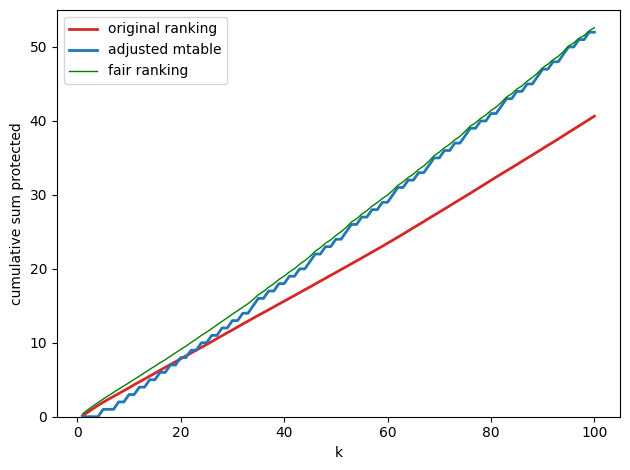

In [57]:
for f_name, _ in prob_functions:
    print(f_name)
    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("cumulative sum protected")

    ax.plot(
        before_fair_cumsum.index[:100],
        before_fair_cumsum.values.flatten()[:100],
        color=color,
        label="original ranking",
        linewidth=2,
    )
    ax.plot(
        range(1, 101), fair.create_adjusted_mtable(), label="adjusted mtable", linewidth=2
    )
    ax.plot(
        after_fair_cumsum[f_name].index,
        after_fair_cumsum[f_name].values.flatten(),
        color="green",
        label="fair ranking",
        linewidth=1,
    )
    ax.set_ylim([0, 55])
    ax.legend()

    fig.tight_layout()
    fig.savefig(f"cumpro_mean_{f_name}.pdf")
    plt.show()

# Changes

In [58]:
def change_count(orginial_rank, fair_rank):
    change_count = 0
    changes_in_pos = []
    for pos in range(len(orginial_rank)):
        if fair_rank[pos] == 1 and sum(orginial_rank[: pos + 1]) != sum(
            fair_rank[: pos + 1]
        ):
            change_count += 1
        changes_in_pos.append(change_count)
    return changes_in_pos

In [59]:
def change_count(orginial_rank, fair_rank):
    return [
        int(
            fair_rank[pos] == 1
            and sum(orginial_rank[: pos + 1]) != sum(fair_rank[: pos + 1])
        )
        for pos in range(len(orginial_rank))
    ]

In [60]:
q_change_count = dict()

for f_name, _ in prob_functions:
    q_change_count[f_name] = change_count(
        [int(q.is_protected) for q in questions_rankings[0][1][:100]],
        [int(q.is_protected) for q in questions_rankings_fair[f_name][0][1]],
    )

safe_balanced


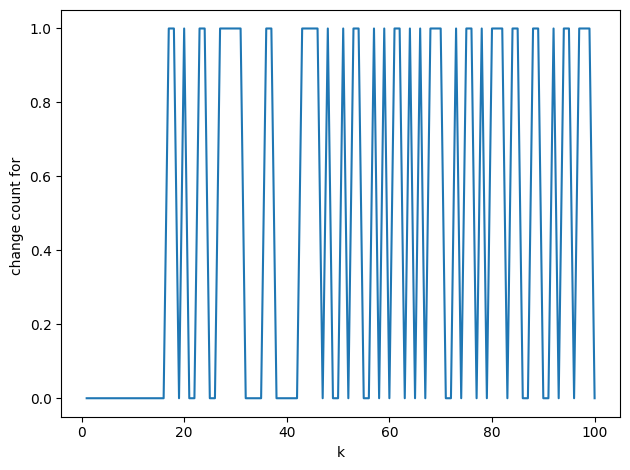

In [61]:
print("safe_balanced")
fig, ax = plt.subplots()

color = "tab:red"
ax.set_xlabel("k")
ax.set_ylabel("change count for ")
ax.plot(range(1, 101), q_change_count["safe_balanced"])

fig.tight_layout()
plt.show()

safe_balanced


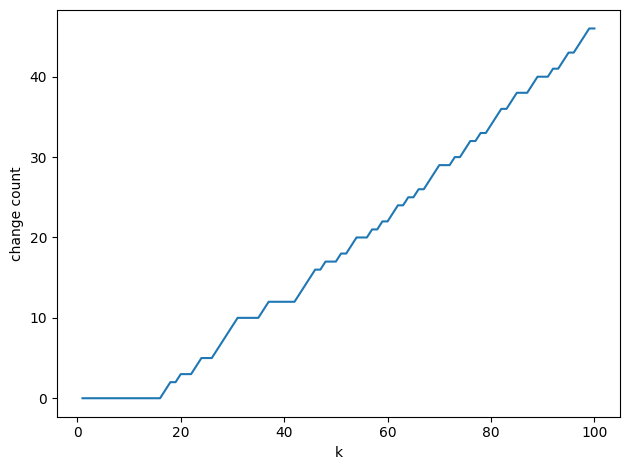

In [62]:
print("safe_balanced")
fig, ax = plt.subplots()

color = "tab:red"
ax.set_xlabel("k")
ax.set_ylabel("change count")
ax.plot(range(1, 101), np.cumsum(q_change_count["safe_balanced"]))

fig.tight_layout()
plt.show()

In [63]:
all_q_change_counts = dict()

for f_name, _ in prob_functions:
    all_q_change_counts_aux = []
    for (_, q_ranking), (q_id, fair_questions) in zip(questions_rankings, questions_rankings_fair[f_name]):
        all_q_change_counts_aux.append(
            change_count(
                [int(q.is_protected) for q in q_ranking[:100]],
                [int(q.is_protected) for q in fair_questions],
            )
        )

    all_q_change_counts[f_name] = np.array(all_q_change_counts_aux)

until_next


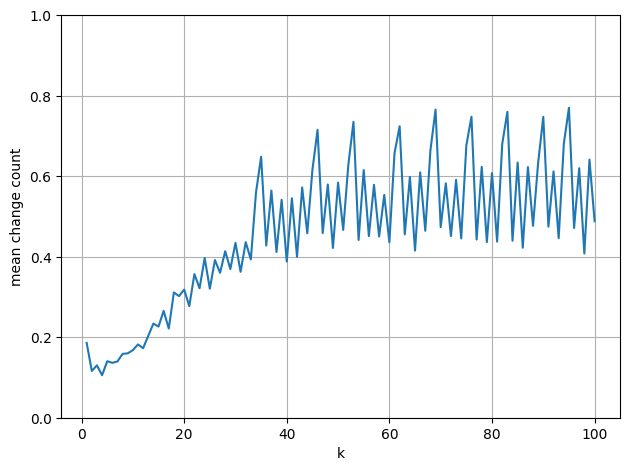

global


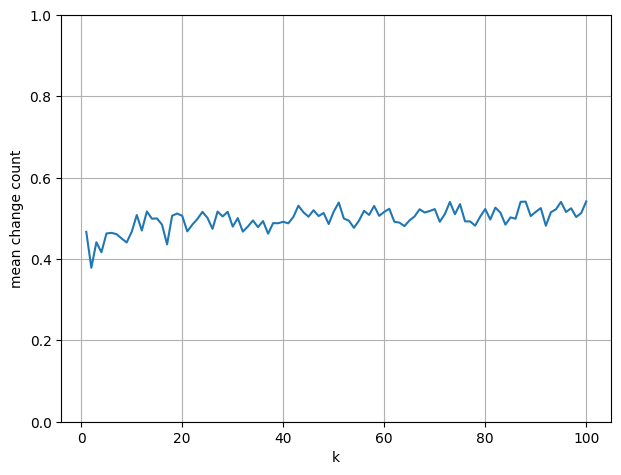

balanced


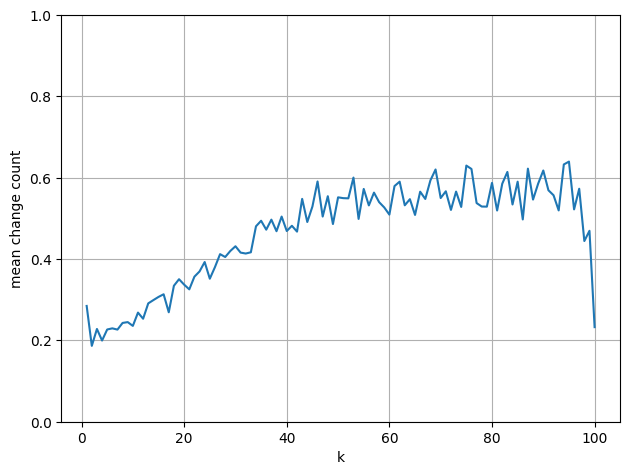

safe_balanced


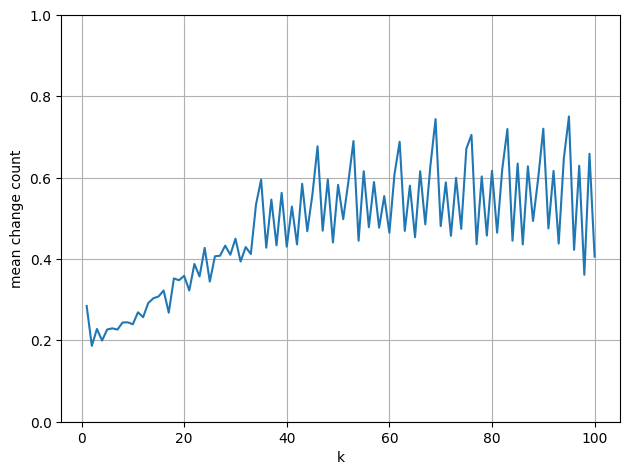

In [64]:
for f_name, _ in prob_functions:
    print(f_name)
    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("mean change count")
    ax.plot(range(1, 101), all_q_change_counts[f_name].mean(axis=0))

    fig.tight_layout()
    ax.set_ylim([0, 1])
    plt.grid()
    fig.savefig(f"chnpos_prob_{f_name}.pdf")
    plt.show()

until_next


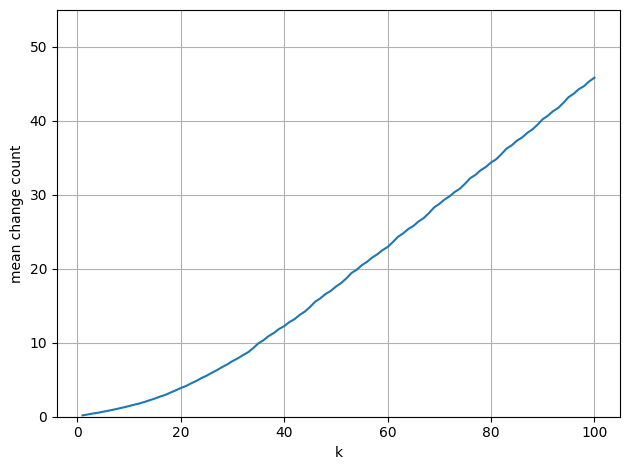

global


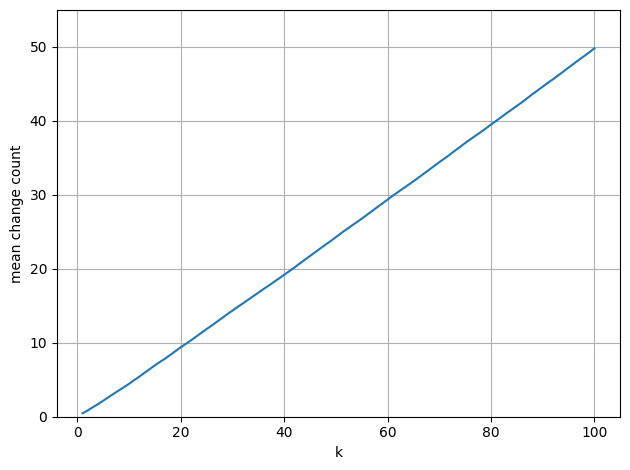

balanced


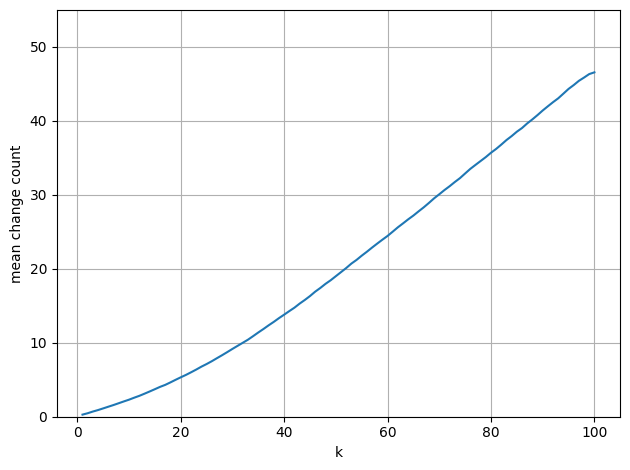

safe_balanced


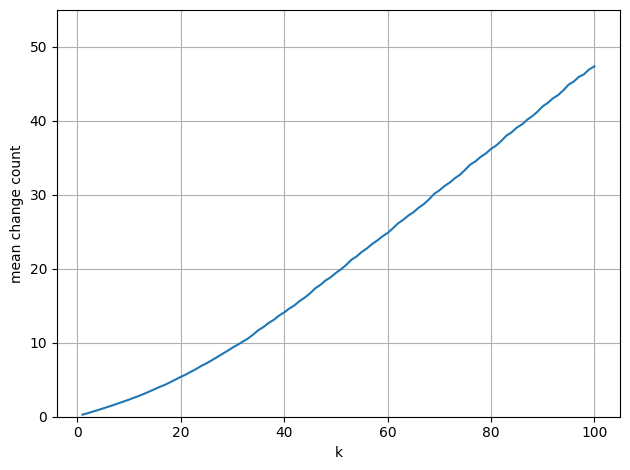

In [65]:
for f_name, _ in prob_functions:
    print(f_name)
    fig, ax = plt.subplots()

    color = "tab:red"
    ax.set_xlabel("k")
    ax.set_ylabel("mean change count")
    ax.plot(range(1, 101), np.cumsum(all_q_change_counts[f_name], axis=1).mean(axis=0))

    ax.set_ylim([0, 55])
    fig.tight_layout()
    plt.grid()
    plt.show()